In [ ]:
import os
import random
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_path  = '/content/gdrive/MyDrive/Garbage classification'
garbage_classes = os.listdir(dataset_path)
print(garbage_classes)

['paper', 'glass', 'metal', 'trash', 'cardboard', 'plastic']


In [ ]:
# Define the target size for image resizing
target_shape = (299, 299) # (width, height) tuple for target size

# Define a series of image transformations to be applied to the dataset
transformations = transforms.Compose([
    transforms.Resize(target_shape), # Resize the image to the target size
    #transforms.Resize((256, 341)),  # Optionally, resize to a different aspect ratio before cropping
    #transforms.RandomCrop(size=target_shape), # Optionally, randomly crop the image to the target size
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    #transforms.Normalize([0.6610, 0.6283, 0.5894], [0.2085, 0.2085, 0.2302]) # Optionally, normalize the image using ImageNet prior statistics
])

# Load the dataset using the ImageFolder class from torchvision.datasets
# This assumes that the dataset is organized into subdirectories, with each subdirectory containing images from a particular class
# The transform parameter specifies the image transformations to be applied to the dataset
dataset = ImageFolder(dataset_path, transform=transformations)


In [ ]:
def display_sample(img, label):
    # Extract the class label from the dataset using the label index
    class_label = dataset.classes[label]
    # Print the class label along with the class number
    print("Label:", class_label, "(Class Number: "+ str(label) + ")")
    # Convert the image tensor to a numpy array and permute the dimensions to (height, width, channels)
    # This is necessary because matplotlib expects the last dimension to be the color channels
    img_np = img.permute(1, 2, 0).numpy()
    # Display the image using matplotlib
    plt.imshow(img_np)


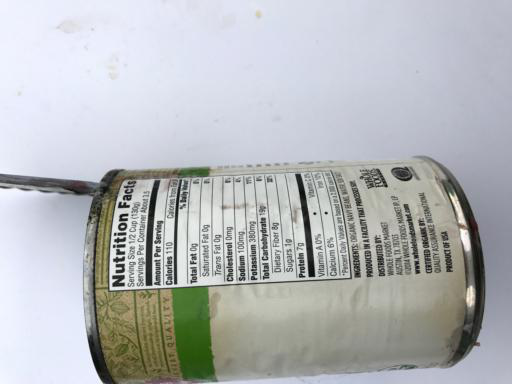

In [ ]:
#Show an example image from the dataset
dataset_example = ImageFolder(dataset_path, transform = None)
image, label = dataset_example[1241]
image

Label: metal (Class Number: 2)


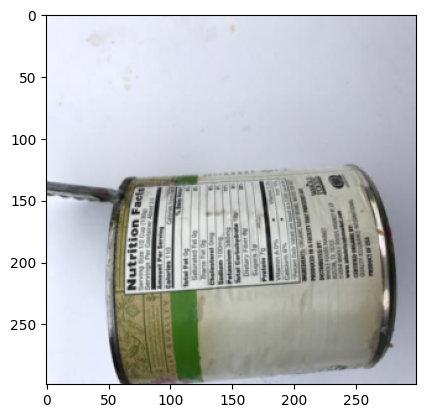

In [ ]:
1# Retrieve a single image and its associated label from the dataset using indexing
# In this case, the 101st image in the dataset is retrieved (Python indexing starts from 0)
image, label = dataset[1241]

# Call the display_sample function to display the image and label
# The display_sample function takes two arguments: the image tensor and its associated label index
display_sample(image, label)


In [ ]:
# Set the random seed for PyTorch using torch.manual_seed
# This ensures that random number generation within PyTorch (e.g. for weight initialization) is deterministic
random_seed = 42
torch.manual_seed(random_seed)

# Set the random seed for Python's built-in random module using random.seed
# This ensures that any other random number generation in the script (e.g. shuffling the dataset) is also deterministic
random.seed(random_seed)

# Set the random seed for NumPy using np.random.seed
# This ensures that any operations involving NumPy arrays (e.g. data preprocessing) are also deterministic
np.random.seed(0)


In [ ]:
train_set, validation_set, test_set = random_split(dataset, [1593, 176, 758])
len(train_set), len(validation_set), len(test_set)

(1593, 176, 758)

In [ ]:
batch_size = 32

In [ ]:
train_dataloader = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dataloader = DataLoader(validation_set, batch_size*2, num_workers = 4, pin_memory = True)
test_dataloader = DataLoader(test_set, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def show_batch(dataloader):
    for images, labels in dataloader:
        # Create a new figure with a size of 12x6 inches
        fig, ax = plt.subplots(figsize=(12, 6))
        # Remove the tick marks from the x and y axes
        ax.set_xticks([])
        ax.set_yticks([])
        # Display the images in a grid using the make_grid function from torchvision.utils
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

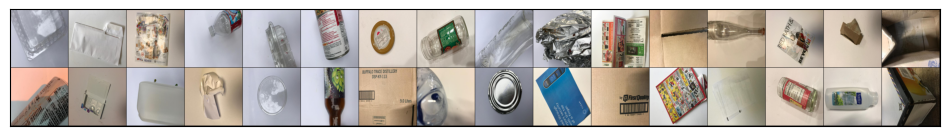

In [ ]:
show_batch(train_dataloader)

In [ ]:
def accuracy(outputs, labels):
    # Use torch.max to get the predicted class for each image in the batch
    # The _, before preds is used to discard the maximum value and only return the index of the maximum value (i.e. the predicted class)
    _, preds = torch.max(outputs, dim=1)
    # Compute the accuracy by comparing the predicted class to the true class labels
    # torch.sum(preds == labels) returns the number of correctly predicted labels in the batch
    # len(preds) returns the total number of labels in the batch
    # Dividing the number of correct predictions by the total number of predictions gives the accuracy
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # Define a training step that takes a batch of data and returns the loss
    def training_step(self, batch):
        images, labels = batch 
        # Pass the images through the network to generate predictions
        generate_predictions = self(images)
        # Calculate the cross-entropy loss between the predictions and the true labels
        loss = F.cross_entropy(generate_predictions, labels)
        return loss
    
    # Define a validation step that takes a batch of data and returns a dictionary of metrics
    def validation_step(self, batch):
        images, labels = batch 
        # Pass the images through the network to generate predictions
        generate_predictions = self(images)
        # Calculate the cross-entropy loss between the predictions and the true labels
        loss = F.cross_entropy(generate_predictions, labels)
        # Calculate the accuracy of the predictions
        acc = accuracy(generate_predictions, labels)
        # Return a dictionary containing the loss and accuracy for the batch
        return {'validation_loss': loss.detach(), 'validation_accuracy': acc}
        
    # Define a validation epoch end function that takes a list of validation outputs and returns the aggregated metrics
    def validation_epoch_end(self, outputs):
        # Extract the losses and accuracies from the validation outputs
        batch_losses = [x['validation_loss'] for x in outputs]
        batch_accs = [x['validation_accuracy'] for x in outputs]
        # Combine the losses and accuracies across all batches
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accs).mean()
        # Return a dictionary containing the aggregated metrics as scalar values
        return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_accuracy.item()}
    
    # Define an epoch end function that takes the epoch number and a dictionary of training and validation metrics
    def epoch_end(self, epoch, result):
        # Print the training and validation metrics for the epoch
        print("Epoch {}: train_loss: {:.4f}, validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(
            epoch+1, result['train_loss'], result['validation_loss'], result['validation_accuracy']))


In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
       # Load the ResNet-50 model pre-trained on ImageNet
        self.network = models.resnet50(pretrained=True)
        # Replace the last fully connected layer to match the number of classes in the dataset
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        # Pass the input tensor through the ResNet-50 model and apply a sigmoid activation to the output
        return torch.sigmoid(self.network(xb))

In [ ]:
model = ResNet()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 259MB/s]


In [ ]:
def get_device():
    """Returns the default device to use for computations"""
    # Use a GPU if available, otherwise use the CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Moves tensors to the specified device"""
    # Recursively move tensors in nested lists/tuples/dicts to the specified device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        return {k: to_device(v, device) for k,v in data.items()}
    return data.to(device, non_blocking=True)

class Device_Data_Loader():
    """Wraps a dataloader to move data to the specified device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to the specified device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Returns the number of batches"""
        return len(self.dl)


In [ ]:
device = get_device()
device

device(type='cuda')

In [ ]:
train_dl = Device_Data_Loader(train_dataloader, device)
val_dl = Device_Data_Loader(val_dataloader, device)
test_dl = Device_Data_Loader(test_dataloader, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model on the validation set"""
    model.eval()
    # Compute the validation loss and accuracy for each batch
    outputs = [model.validation_step(batch) for batch in val_loader]
    # Combine the losses and accuracies for all batches
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    """Trains the model and returns the training history and the best model"""
    history = []
    best_val_loss = 10
    trigger = 0
    patient = 7
   
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            # Compute the loss for the current batch, perform backpropagation, and update the model parameters
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        # Compute the average training loss for the current epoch and add it to the results
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # Print the epoch results and add them to the history
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Reduce the learning rate using the scheduler
        scheduler.step(result['validation_loss'])
        
        # Perform early stopping if the validation loss does not improve after a certain number of epochs
        if result['validation_loss'] >= best_val_loss:
            trigger += 1
            print('Trigger time', trigger)
            if trigger > patient:
                # Stop training early and return the training history and the best model obtained so far
                return history, best_model
        else:
            # Update the best validation loss and save a copy of the current model
            best_val_loss = result['validation_loss']
            best_model = copy.deepcopy(model)
            trigger = 0
                
    # Return the training history and the best model obtained during training
    return history, best_model


In [ ]:
model = to_device(model, device)

In [ ]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in the model.

    Args:
    - model: a PyTorch model.

    Returns:
    - The total number of trainable parameters in the model.
    """
    # Use a generator expression to iterate over the model parameters and count the number of trainable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Call the count_parameters() function with the model as input and print the result
count_parameters(model)


23520326

In [ ]:
num_epochs = 30
lr = 0.000055
# Choose an optimizer and set the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set up a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, factor=0.9, patience=3, cooldown=0, min_lr=0, verbose=True)

# Train the model and save the best performing model based on validation loss
history, best_model = fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

Epoch 1: train_loss: 1.0461, validation_loss: 1.1317, validation_accuracy: 0.9219
Epoch 2: train_loss: 1.0477, validation_loss: 1.1061, validation_accuracy: 0.9479
Epoch 3: train_loss: 1.0453, validation_loss: 1.0938, validation_accuracy: 0.9583
Epoch 4: train_loss: 1.0449, validation_loss: 1.0892, validation_accuracy: 0.9601
Epoch 5: train_loss: 1.0445, validation_loss: 1.0924, validation_accuracy: 0.9583
Trigger time 1
Epoch 6: train_loss: 1.0468, validation_loss: 1.1023, validation_accuracy: 0.9497
Trigger time 2
Epoch 7: train_loss: 1.0498, validation_loss: 1.1219, validation_accuracy: 0.9167
Trigger time 3
Epoch 8: train_loss: 1.0502, validation_loss: 1.1160, validation_accuracy: 0.9444
Epoch 00008: reducing learning rate of group 0 to 4.9500e-05.
Trigger time 4
Epoch 9: train_loss: 1.0499, validation_loss: 1.0863, validation_accuracy: 0.9566
Epoch 10: train_loss: 1.0456, validation_loss: 1.0943, validation_accuracy: 0.9583
Trigger time 1
Epoch 11: train_loss: 1.0447, validation_l

In [ ]:
evaluate(best_model, val_dl)

In [ ]:
evaluate(best_model, test_dl)

In [ ]:
torch.save(best_model, "dataminemodel.h5")
modelsample = torch.load("dataminemodel.h5")

In [ ]:
modelsample = torch.load("dataminemodel.h5")

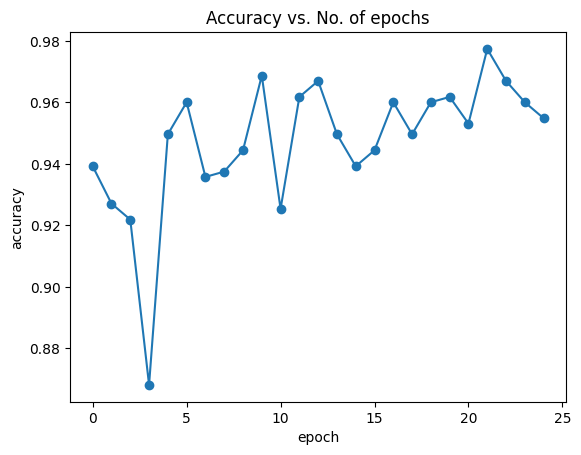

In [ ]:
def plot_accuracy(history):
    accuracies = [i['validation_accuracy'] for i in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracy(history)

In [ ]:
def plot_losses(history):
    """
    Plots the training and validation losses vs. number of epochs.

    Args:
    - history: a list of dictionaries containing the loss and accuracy metrics for each epoch during training.

    Returns:
    - None
    """
    # Extract the training and validation loss values for each epoch from the history dictionary
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    # Plot the training losses as a green line and validation losses as a purple line
    plt.plot(train_losses, color='blue', linestyle='-', label='Training')
    plt.plot(val_losses, color='orange', linestyle='-', label='Validation')
    # Label the x-axis
    plt.xlabel('Epoch')
    # Label the y-axis
    plt.ylabel('Loss')
    # Add a legend to the plot
    plt.legend()
    # Add a title to the plot
    plt.title('Training and Validation Loss vs. Epoch')

# Call the plot_losses() function with the history as input
plot_losses(history)


In [ ]:
preds = torch.zeros((0,6)).cuda()
labels = torch.zeros((0)).cuda()
best_model.eval()
with torch.no_grad():
    for i, (images, label) in enumerate(test_dl):
        pred = best_model(images)
        preds = torch.cat((preds,pred),dim = 0)
        labels = torch.cat((labels,label.float()))

# one hot encoding test labels
y_true = np.zeros(preds.shape)
for i in range (preds.shape[0]):
    for j in range(preds.shape[1]):
        y_true[i][j] = 1 if labels[i]== j else 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = preds.shape[1]
out = preds.cpu().detach().numpy()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], out[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), out.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(dataset.classes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of multiclass prediction")
plt.legend(loc="lower right")
plt.show()

In [ ]:
_, y_pred = torch.max(preds, dim=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = [dataset.classes[i] for i in range(6)]
print(classification_report(labels.cpu(), y_pred.cpu(), target_names = target_names))
print('Note: In binary classification, recall of the positive class is also known as “sensitivity”; \n\
recall of the negative class is “specificity”.')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import gc
gc.collect()

y_pred = []
y_true = []
#y_true = []
classes = ('paper', 'glass', 'metal', 'trash', 'cardboard', 'plastic')
#preds = torch.zeros((0,6)).cuda()
#labels = torch.zeros((0)).cuda()
#best_model.eval()
with torch.no_grad():
    for i, (images, label) in enumerate(test_dl):
        output = best_model(images)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = label.data.cpu().numpy()
        y_true.extend(labels)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[15]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[18]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))